<a href="https://colab.research.google.com/github/acifajkya/PopulationInference/blob/main/JupyterNotebooks/intro_HBA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Bayesian analysis for GW population inference

Our goal will be to self-consistency infer population parameters $\Lambda$ by sampling this posterior:

\begin{equation}
p(\Lambda|\{d\},\{\theta\},) \propto p(\Lambda) e^{-N_{\rm exp}(\Lambda)}\prod_i^{N_{\rm ev}} p(d_i|\theta_i) \frac{{\rm d} N}{{\rm d} \theta} (\theta_i;\Lambda)
\end{equation}

We will go through each object in turn and then put it all together at the end, with a short demo on sampling with HMC.

In [1]:
# UNCOMMENT THE BELOW IF RUNNING ON GOOGLE COLAB
!pip install numpy matplotlib h5ify
!pip install jax numpyro arviz
!pip install wcosmo
!mkdir -p inputs
!wget https://github.com/afarah18/HBA-for-GWs-tutorial/raw/refs/heads/main/inputs/pe.h5 -P inputs
!wget https://github.com/afarah18/HBA-for-GWs-tutorial/raw/refs/heads/main/inputs/endo3_bbhpop-LIGO-T2100113-v9.hdf5 -P inputs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.3 MB/s eta 0:00:00
--2025-06-26 07:20:52--  https://github.com/afarah18/HBA-for-GWs-tutorial/raw/refs/heads/main/inputs/pe.h5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/afarah18/HBA-for-GWs-tutorial/refs/heads/main/inputs/pe.h5 [following]
--2025-06-26 07:20:53--  https://raw.githubusercontent.com/afarah18/HBA-for-GWs-tutorial/refs/heads/main/inputs/pe.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

In [2]:
# standard packages
import numpy as np
import matplotlib.pyplot as plt
import h5ify

# inference (numpyro and friends)
import numpyro
import numpyro.distributions as dist
import arviz as az
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit

# our own packages
import wcosmo
wcosmo.disable_units()

## $\frac{{\rm d} N (\Lambda)}{{\rm d} \theta} $
This is the merger rate density of CBCs: the expected number of events per single-event-parameter ($\theta$) hypervolume, conditioned on hyper-parameters $\Lambda$. Colloquially, this is called "the population model."
It is common to model this as
\begin{equation}
    \frac{{\rm d} N}{{\rm d} \theta} (\theta;\Lambda) = \mathcal{R}p(\theta|\Lambda) ,
\end{equation}
where $\mathcal{R}$ is the total merger rate and $p(\theta|\Lambda)$ is normalized over $\theta$.

We will adopt a simple parametric form for $p(\theta|\Lambda)$ using power laws, assume independent distributions of masses and redshifts, and ignore spins and any extrinsic parameters:

\begin{aligned}
    p(m_1,q,z|\Lambda) & = p(m_1,q|\lambda_m)p(z,\lambda_z)
\end{aligned}
where  
\begin{aligned}
    \lambda_m &=\{m_{\min},m_{\max},\alpha,\beta\}, \\
    \lambda_z &=\{z_{\max},\kappa\}, \\
    p(m_1,q|\lambda_m) &\propto \begin{cases}
    m_1^{\alpha} &\mathrm{ if }\ m_1\in [m_{\min},m_{\max}] \\
    0 &\mathrm{ otherwise} \\
    \end{cases} \times \begin{cases}
    q^{\beta} &\mathrm{ if } q \in [m_{\min}/m_1,1] \\
    0 &\mathrm{ otherwise} \\
    \end{cases}\ \mathrm{ , and} \\
    p(z|\lambda_z) &\propto \frac{{\rm d}V_c}{{\rm d}z} \frac{1}{1+z} \begin{cases}
    (1+z)^{\kappa} &\mathrm{ if }\ z\in [0,z_{\max}] \\
    0 &\mathrm{ otherwise} \\
    \end{cases} .
\end{aligned}
Here, ${\rm d}V_c/{\rm d}z$ is the differential comoving volume. We need to choose a maximum redshift, $z_{\max}$ so that our probability distributions are normalizable. This is not a physical parameter and is therefore always fixed, not fit along with the other hyperparameters. It should be chosen to lie far beyond the detector horizon so as not to have an impact on the inference.

In [4]:
ZMAX = 1.9

@jit
def _smoothed_powerlaw_unnormed(x,slope,minimum,maximum,smoothing):
    low_start = minimum + smoothing
    high_start = maximum - smoothing
    low_filter = jnp.exp(-(x - low_start)**2/(2.*smoothing**2))
    low_filter = jnp.where(x < low_start,low_filter,1.)
    high_filter = jnp.exp(-(x - high_start)**2/(2.*smoothing**2))
    high_filter = jnp.where(x > high_start,high_filter,1.)
    return jnp.power(x,slope) * low_filter * high_filter

@jit
def _smoothed_powerlaw(x,slope,minimum,maximum,smoothing):
    """a power law distribution that is smoothed at the edges (for HMC happiness).
    p(x|slope,minimum,maximum) \propto x^slope between minimum and maximum.
    Approximately normalized, (for small smoothing lengths).
    """
    approxnorm = (1 + slope) / jnp.array(jnp.power(maximum, 1 + slope) - jnp.power(minimum, 1 + slope))
    return _smoothed_powerlaw_unnormed(x,slope,minimum,maximum,smoothing) / approxnorm

@jit
def p_m1(m1,alpha,mmin,mmax):
    """a power law primary mass distribution. """
    return _smoothed_powerlaw(x=m1,slope=alpha,minimum=mmin,maximum=mmax,smoothing=.8)

@jit
def p_q_given_m1(q, m1, beta, mmin):
    """a power law mass ratio distribution.
    Note that the minimum allowed mass ratio depends on m1, so this is always conditional on m1."""
    return _smoothed_powerlaw(x=q,slope=beta,minimum=mmin/m1,maximum=1.,smoothing=0.01)

@jit
def p_z_unnormed(z,kappa,zmax=ZMAX):
    """a power law redshift distribution, normalized s.t. the powerlaw returns 1 at z=0."""
    _zmin = 1e-3 # just set this to be close to zero to avoid zero-division errors
    dVc_dz = wcosmo.Planck15.differential_comoving_volume(z) * 4 * jnp.pi
    return dVc_dz * _smoothed_powerlaw_unnormed(1+z, kappa - 1, 1+_zmin, 1+zmax, smoothing=0.02)

@jit
def p_z(z,kappa,zmax=ZMAX):
    """a power law redshift distribution, normalized to a aribtrary maximum redshift zmax."""
    _zmin = 1e-3 # just set this to be close to zero to avoid zero-division errors
    _z_dummy = jnp.linspace(_zmin,zmax,num=int(1e3))
    norm = jnp.trapezoid(y=p_z_unnormed(_z_dummy,kappa=kappa,zmax=zmax), x=_z_dummy)
    return p_z_unnormed(z,kappa,zmax) / norm

@jit
def p_theta_given_Lambda(m1,q,z,alpha,mmin,mmax,beta,kappa,zmax=ZMAX):
    return p_m1(m1,alpha,mmin,mmax) * p_q_given_m1(q,m1,beta,mmin) * p_z(z,kappa,zmax)

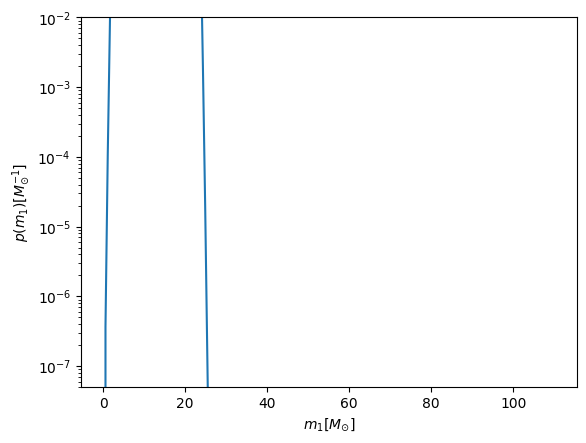

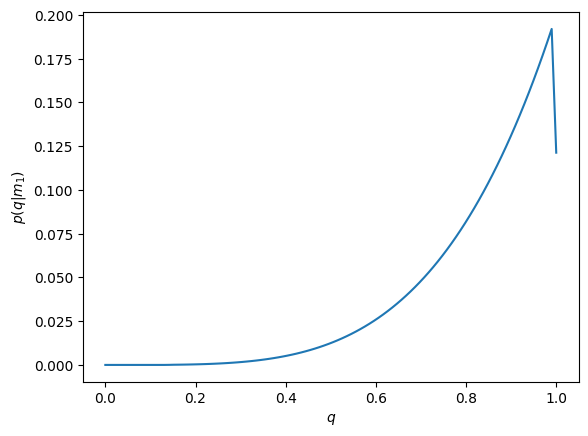

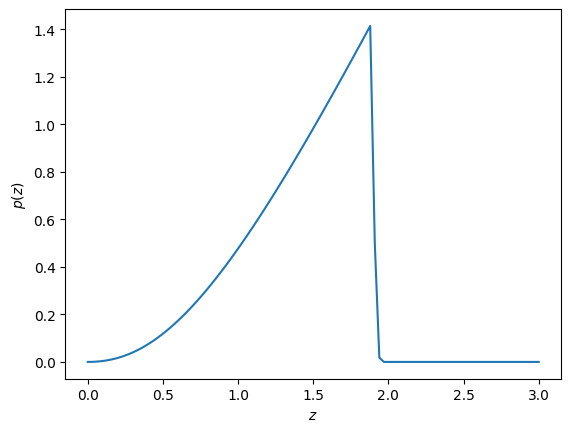

In [24]:
m1_plotting = np.linspace(0,110,num=200)
q_plotting = np.linspace(0,1,num=100)
z_plotting = np.linspace(0,3,num=100)

# TODO: fill me in!
Lambda = dict(
    alpha= 2,
    beta= 4,
    kappa= 3,
    mmin= 5,
    mmax= 20
)

plt.semilogy(m1_plotting,p_m1(m1_plotting,Lambda['alpha'],Lambda['mmin'],Lambda['mmax']))
plt.xlabel("$m_1 [M_{\odot}]$")
plt.ylabel("$p(m_1) [M_{\odot}^{-1}]$")
plt.ylim(5e-8,1e-2)
plt.show()

plt.plot(q_plotting,p_q_given_m1(q_plotting,m1=35,beta=Lambda['beta'],mmin=Lambda['mmin']))
plt.xlabel("$q$")
plt.ylabel("$p(q|m_1)$")
plt.show()

plt.plot(z_plotting,p_z(z_plotting,Lambda['kappa']))
plt.xlabel("$z$")
plt.ylabel("$p(z)$")
plt.show()

## $p(d_i|\theta_i)$
This is the single-event likelihood: the probability of observing the data $d_i$ associated with event $i$ given single-event paramters $\theta_i$. Yesterday's tutorials and talks discussed how we can get single-event posteriors though parameter estimation (PE). Instead of repeating the whole PE process for every event in the catalog while we simultanously infer population parameters, we are going to use a trick called "sample recycling." This uses posterior samples pre-calculated with yesterday's method (often called "PE samples") and divides by their prior ("the PE prior", $\pi_{\rm PE}$) to get samples from the single-event likelihoods. This is the most common method of sampling from $p(d_i|\theta_i)$ in GW population studies.

To do the sample recylcing trick, we first load in PE samples done for GWTC-3. To simplify things, this only includes events detected in O3. Note that the full PE results have lots of information in them that is not used in population analyses. Thus, a lot of data cleaning has been done on the samples we are about to load in (thanks, Matt!). Consider using `gwpopulation_pipe` to do similar data cleaning on samples that you download from GWTC data releases.

In [17]:
# load in PE samples
posteriors_T = h5ify.load('inputs/pe.h5')
# re-arrange the data and ignore all parameters except for masses and redshift
N_PE_samples = posteriors_T['GW190412']['mass_1_source'].size
posteriors = {
    k: jnp.array([posteriors_T[event][k] for event in sorted(posteriors_T)])
    for k in ["mass_1_source","mass_ratio","redshift","prior"]
}
# take a look at the first sample of the first 10 events
{k:posteriors[k][:10,0] for k in posteriors.keys()}

{'mass_1_source': Array([25.30252341, 33.34766421, 31.71413937, 51.62935454, 41.29137362,
        37.68706737, 26.77189268, 41.69191622, 46.68099861, 69.80313116],      dtype=float64),
 'mass_ratio': Array([0.85508493, 0.23392975, 0.78264024, 0.79269092, 0.91241636,
        0.58905126, 0.44182733, 0.41916133, 0.47702821, 0.38543271],      dtype=float64),
 'redshift': Array([0.19335228, 0.14394594, 0.67489138, 0.50082044, 0.32384426,
        0.28944589, 0.2123273 , 0.38668733, 0.26587526, 0.3664602 ],      dtype=float64),
 'prior': Array([1.88227102, 5.58541593, 0.91473906, 0.74590903, 0.81840567,
        2.24887668, 2.01986668, 1.71035509, 0.74683545, 0.9355775 ],      dtype=float64)}

### A note about event selection
GW detection pipelines identify many GW event candidates. We are then free to set selection criteria on these candidates for inclusion in population analyses. However, it is crucial that these criteria are applied consistently throughout the analysis. Any choice made on real GW event candidates must be made on injections. These choices will set $N_{\rm ev}$ and $N^{\rm inj}_{\rm found}$, so you can think of setting these criteria as equivalent to defining what a catalog is.

For example, a choice based on real event parameters is impossible to apply consistently between injections and real events, as we don't know the true event parameters before doing a population analysis, but we do know the true parameters for injections. In practice, we often break this rule: a BBH-only analysis requires a cut on true secondary mass (usually $m_2\gtrsim2.5 M_{\odot}$) to exclude NS-containing events, but its important to know when you are breaking this rule and test that the effects are small. It turns out that cutting on mass is a smaller effect than using different significance thresholds (e.g. true SNR, observed SNR, FAR) for injections and data.

**The events we loaded in here are BBHs ($m_2>3 M_{\odot}$) detected in O3 with a false alarm rate (FAR) of less than $1/{\rm year}$.**

## $p(d_i|\theta_i) \frac{{\rm d} N}{{\rm d}\theta}(\theta_i;\Lambda)$

Putting the above two sections together, we can now get the expression in the product in the population likelihood, namely

\begin{equation}
p(d_i|\theta_i) \frac{{\rm d} N}{{\rm d}\theta}(\theta_i;\Lambda).
\end{equation}

This is proportional to the population-informed individual event posterior for each event.

Dividing this by the total merger rate yeilds $p(d_i|\theta_i) p(\theta|\Lambda)$. Since $p(\theta|\Lambda)$ can be interpreted as a prior on $\theta$ (usually called the "population prior"), the above expression is proportional to the "population-informed individual-event posterior." We will examine this for a single event.

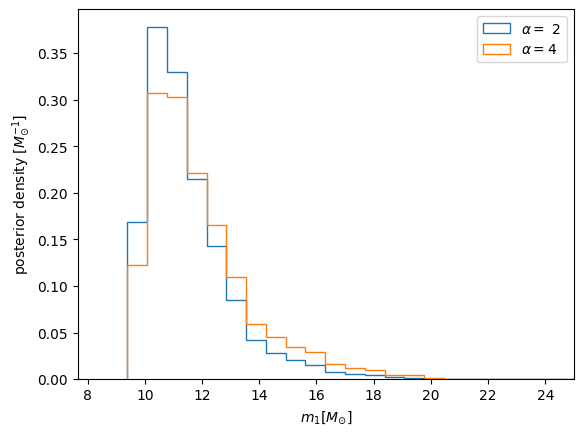

In [20]:
# arbitrarily choose one event from the catalog
example_event = posteriors_T['GW190728_064510']
# divide by the PE prior to get the single-event likelihood, multiply by the population prior to get the population-informed posterior

weights = p_theta_given_Lambda(m1=example_event['mass_1_source'],q=example_event['mass_ratio'],z=example_event['redshift'],**Lambda
                               )/example_event['prior']

plt.hist(example_event['mass_1_source'],weights=weights,bins=50,density=True,histtype='step',label=f"$\\alpha=$ {Lambda['alpha']}")

# compare with another choice of primary mass power law slope
Lambda2 = Lambda.copy()
Lambda2['alpha']= 4 # TODO: fill me in!
weights2 = p_theta_given_Lambda(m1=example_event['mass_1_source'],q=example_event['mass_ratio'],z=example_event['redshift'],**Lambda2
                               )/example_event['prior']
plt.hist(example_event['mass_1_source'],weights=weights2,bins=50,density=True,histtype='step',label=f"$\\alpha=${Lambda2['alpha']}")

plt.xlabel("$m_1 [M_{\odot}]$")
plt.ylabel("posterior density $[M_{\odot}^{-1}]$")
plt.legend()
plt.xlim(right=25)
plt.show()

The population prior has a noticable effect on the parameters we infer for our events! This is why population analyses are necessary for individual-event interpretation.

Often, we marginalize over the possible properties of each event:
\begin{equation}
    p(\{d\}|\Lambda) \propto e^{-N_{\text{exp}}(\Lambda)}\prod_i^{N_{\text{ev}}} \int
    d\theta_i\, p(d_i|\theta_i) \frac{{\rm d} N}{ {\rm d} \theta} (\theta_i;\Lambda)
\end{equation}
If we wished to simultaneously infer the properties of individual events along with the population hyper-parameters, we simply would not marginalize over those events' parameters, and instead perform a high-dimensional inference, as in [ Mancarella & Gerosa 2025](https://ui.adsabs.harvard.edu/abs/2025PhRvD.111j3012M/abstract).

We can do this marginalization with a Monte Carlo sum over PE samples:
\begin{equation}
    \int {\rm d} \theta_i\, p(d_i|\theta_i) \frac{{\rm d} N}{{\rm d} \theta} (\theta_i;\Lambda) \approx \frac{1}{N_{\rm samps}} \sum_{k=1}^{N_{\rm samps}} \frac{\frac{{\rm d} N}{{\rm d} \theta} (\theta_{k,i};\Lambda)}{\pi_{\rm PE}(\theta_{k,i})} .
\end{equation}

In [21]:
# the MC integral for the above-considered event is simply
weights.sum() / N_PE_samples

Array(42.38020305, dtype=float64)

## $N_{\rm exp}(\Lambda)$

This is the expected number of detections in our catalog, as defined by our event selection. This is simply the rate of CBCs in the Universe (${\rm d} N/{\rm d} \theta$) multiplied by the probability of detecting an event with those parameters and given a noise realization $n$, $P(\det|\theta,n)$.
The total number of expected detections is then obtained simply by summing the contributions from each value of every source parameter, i.e. marginalizing over $\theta$ and $t_{{\rm d}et}$:
\begin{equation}
    N_{\text{exp}}(\Lambda) = \int{\rm d}\theta \frac{{\rm d} N}{ {\rm d} \theta} (\theta;\Lambda) P(\det|\theta,n) \, .
\end{equation}

*Aside:* GW experiments are unique because $P(\det|\theta,n)$ is precisely knowable for GWs from CBCs, which is nontrivial for other astrophysical messengers, which typically have large theoretical uncertainties in the models that connect their source parameters to their observability.
Because GR provides a complete mapping from source properties $\theta$ to the GW signal, we are able to "undo" GW selection biases.
Often in the GW literature, all possible noise realizations are marginalized over to write $P(\det|\theta)$.
In practice, though, this marginalization is not precise as a complete detector noise model does not exist.
Thus, analyses either work under the assumption of stationary Gaussian detector noise, or the observed strain data is used as the detector noise realization and no marginalization is performed.

$N_{\text{exp}}(\Lambda)$ is typically calculated using "software injections."
Software injections are a large set of $N_{\rm inj}$ samples drawn from a known distribution $p_{\rm draw}(\theta^{\rm inj})$.
These are then "injected" in the data stream by calculating the waveforms that would be made by each draw's source parameters and adding this to the strain measured by the detectors.
Finally, the search pipelines that are used to identify real GW events are run on the data stream that has been injected with the simulated signals, resulting in significance estimates for each injection, such as a FAR.
Applying *the same selection criteria as we defined for real events* to these injections results in $N_{\rm found}$ found injections with known true parameters $\theta^{\rm inj}$.
$N_{\text{exp}}(\Lambda)$ can then be approximated with a Monte-Carlo sum over *found* injections, as $P(\det|\theta^{\rm inj},n)$ is zero when the injection is not found:
\begin{equation}
    N_{\text{exp}}(\Lambda) \approx \frac{1}{N_{\rm inj}}\sum_j^{N_{\rm found}} \frac{{\rm d} N}{{\rm d} \theta} (\theta^{\rm inj};\Lambda) \frac{1}{p_{\rm draw}(\theta^{\rm inj}_j)} .
\end{equation}

In [22]:
# load O3 software injections and only keep fields we will use. Some of the below code is borrowed from gwpopulation_pipe
full_injections = h5ify.load('inputs/endo3_bbhpop-LIGO-T2100113-v9.hdf5')['injections']
keys_subset = ["mass1_source","mass2_source","redshift","mass1_source_mass2_source_sampling_pdf","redshift_sampling_pdf",]
for substr in ["far"]:
    keys_subset += [
        key
        for key in full_injections.keys()
        if any(
            [
                key.startswith(f"{substr}_"),
                key.endswith(f"_{substr}"),
                f"_{substr}_" in key,
            ]
        )
    ]
injections = {k : full_injections[k] for k in keys_subset}

In [23]:
# Select injections based on catalog definition
threshold_FAR =  # TODO: fill this in with the false alarm rate used to select events above
threshold_m2 =  # TODO: fill this in with the mass cut used to select BBHs above

# First, select on what we consider to be a BBH
# (again, this is technically inconsistent between real events and injections because the latter is on the data level and the former is on the event-parameter level).
BBH_injections = {k : injections[k][ injections['mass2_source'] > threshold_m2 ] for k in keys_subset}
N_inj = len(BBH_injections['mass1_source'])

# Then, select on the significance of each trigger.
# We typically consider an event that meets this criteria in *any* detection pipeline to be part of the catalog,
# hence the "or" statement below (i.e. |= )
found_bool = np.zeros(N_inj,dtype=bool)
for key in keys_subset:
    if "far" in key:
        found_bool |= BBH_injections[key] < threshold_FAR
# NOTE: We are downsampling the found injections to 10,000 for the sake of this tutorial just to make the inference run faster.
# This is very bad, don't do this in production runs! It will increase your MC variance and that's a big issue for us.
found_BBH_injections = {k : jnp.array(BBH_injections[k][found_bool][:10000],dtype='float64') for k in keys_subset}

SyntaxError: invalid syntax (ipython-input-23-531243738.py, line 2)

In [ ]:
# calculate the terms in the Nexp sum
# we will reuse the same Lambda as above, just for demonstration

# first, dN/dtheta(theta;Lambda)
local_rate_per_time = 15 / 1e9 # per kpc^3 per year
observing_time = 1 # 1 year in O3
z_dummy = jnp.linspace(0,ZMAX,num=int(1e3))
total_rate = local_rate_per_time * observing_time * np.trapz(y=p_z_unnormed(z_dummy,kappa=Lambda['kappa']))

dN_dtheta = # TODO: fill me in!

# second, pdraw
pdraw = found_BBH_injections['mass1_source_mass2_source_sampling_pdf'] * found_BBH_injections['redshift_sampling_pdf']
# this is defined over m1, m2, and z. However, p(theta|Lambda) is defind over m1, q, and z,
# so we need to multiply by the Jacobian between m2 and q to match units
pdraw *= found_BBH_injections['mass1_source']
found_BBH_injections['pdraw'] = pdraw

# finally, put them together
weights = dN_dtheta / pdraw
Nexp = np.sum(weights) / N_inj
# display the number of expected BBH in O3 under this population model. Is it consistent with how many events we observed in O3?
Nexp

In [ ]:
# TODO: change Lambda and see how Nexp is affected.
# Can you guess what hyperparameter choices would increase or decrease the expected number of observations?
Lambda = dict(
    alpha= 2,
    beta= 4,
    kappa= 3,
    mmin= 5,
    mmax= 20
)
# calculate the terms in the Nexp sum
# we will reuse the same Lambda as above, just for demonstration

# first, dN/dtheta(theta;Lambda)
local_rate_per_time = 15 / 1e9 # per kpc^3 per year
observing_time = 1 # 1 year in O3
z_dummy = jnp.linspace(0,ZMAX,num=int(1e3))
total_rate = local_rate_per_time * observing_time * np.trapz(y=p_z_unnormed(z_dummy,kappa=Lambda['kappa']))

dN_dtheta = total_rate * p_theta_given_Lambda(
    m1=found_BBH_injections['mass1_source'],
    q=found_BBH_injections['mass2_source']/found_BBH_injections['mass1_source'],
    z=found_BBH_injections['redshift'],
    alpha=Lambda['alpha'],
    beta=Lambda['beta'],
    mmin=Lambda['mmin'],
    mmax=Lambda['mmax'],
    kappa=Lambda['kappa'],
)

# second, pdraw
pdraw = found_BBH_injections['mass1_source_mass2_source_sampling_pdf'] * found_BBH_injections['redshift_sampling_pdf']
# this is defined over m1, m2, and z. However, p(theta|Lambda) is defind over m1, q, and z,
# so we need to multiply by the Jacobian between m2 and q to match units
pdraw *= found_BBH_injections['mass1_source']
found_BBH_injections['pdraw'] = pdraw

# finally, put them together
weights = dN_dtheta / pdraw
Nexp = np.sum(weights) / N_inj
# display the number of expected BBH in O3 under this population model. Is it consistent with how many events we observed in O3?
Nexp

In [ ]:
# to get a feel for the selction effects, plot P(det | theta) for each parameter. This is not sensitive to pdraw or Lambda
plt.hist(found_BBH_injections['mass1_source'],density=True,bins=50,histtype='step',
         weights=1/found_BBH_injections['pdraw']
)
plt.xlabel("$m_1 [M_{\odot}]$")
plt.ylabel("observed population $[M_{\odot}^{-1}]$")
plt.show()

plt.hist(found_BBH_injections['mass2_source']/found_BBH_injections['mass1_source'],density=True,bins=50,histtype='step',
         weights=1/found_BBH_injections['pdraw']
         )
plt.xlabel("mass ratio")
plt.ylabel("observed population $[M_{\odot}^{-1}]$")
plt.show()

plt.hist(found_BBH_injections['redshift'],density=True,bins=50,histtype='step',
         weights=1/found_BBH_injections['pdraw']
         )
plt.xlabel("redshift")
plt.ylabel("observed population")
plt.show()

## Sampling the population posterior
We are now ready to put this all together and perform a hierarchical Bayesian inference to infer $\Lambda$. For this, we will use a probablistic programming library that allows us to more intuitively follow the DAG:

<img src="https://github.com/afarah18/HBA-for-GWs-tutorial/blob/main/DAG.png?raw=1" alt="DAG" width="300"/>

I'm using `numpyro`, but you could use `pyro`, `stan`, or another probabilistic programming language in a similar fashion. In `numpyro`,
```python
x = numpyro.sample("name",dist.p(q))
```
samples a random variable, `x` named `"name"` from a probability distribution `dist.p` defined parametrized by `q`, and records `p(x|q)` this as the prior probability of `x`. It is equivalent to $x\sim p(x|q)$.

In [ ]:
# Define the population posterior
def population_posterior(data,found_injections, N_total_injections, observing_time):
    # Top level of the DAG: draw Lambda from p(Lambda).
    # We will use uniform priors on most of our hyperparameters for simplicity
    alpha = numpyro.sample("alpha", dist.Uniform(   )) # TODO: fill in some prior bounds for this power law slope that you think are reasonable
    beta = #TODO: fill me in!
    kappa = #TODO: fill me in!
    mmin = numpyro.sample("mmin", dist.Uniform(3,10)) # use 3 as the minimum because our injections don't exist below there
    mmax = numpyro.sample("mmax", dist.Uniform(30,100)) # use 100 as maximum because our injections don't exist above there
    local_rate = numpyro.sample('local_rate',dist.TruncatedNormal(loc=15.,scale=30.,low=0.01)) # Volumetric rate
    total_number = local_rate * observing_time * jnp.trapezoid(y=p_z_unnormed(z_dummy,kappa=kappa)) / 1e9

    # Prod [ \int( p(d_i|theta_i) dN/dtheta(theta_i;Lambda) ) ]
    ## single-event posteriors

    p_theta_i_given_Lambda = #TODO: fill me in!

    ## marginalize over theta_i and multiply by the rate
    dN_dtheta_i = jnp.sum( p_theta_i_given_Lambda / data['prior'] ,axis=1)
    ## record the data terms. We take the log because numpyro expects log probabilities, and sum all single-event terms
    numpyro.factor("logp",jnp.sum(jnp.log(total_number) + jnp.log(dN_dtheta_i) - jnp.log(N_PE_samples)))

    # Nexp
    ## dN/dtheta(theta;Lambda)
    dN_dtheta = total_number * p_theta_given_Lambda(
        m1=found_injections['mass1_source'],
        q=found_injections['mass2_source']/found_injections['mass1_source'],
        z=found_injections['redshift'],
        alpha=alpha,
        beta=beta,
        mmin=mmin,
        mmax=mmax,
        kappa=kappa,
)
    ## pdraw
    pdraw = found_injections['pdraw']

    Nexp = # TODO: fill me in!
    ## record log( exp( -Nexp ) )  term
    numpyro.factor("Nexp",-1 * Nexp)

In [ ]:
# Sample it with numpyro's Hamiltonian monte carlo method (the No U-Turn Sampler, specifically)
jax_rng = jax.random.PRNGKey(42)
nuts_settings = dict(target_accept_prob=0.9, max_tree_depth=10,dense_mass=False)
nuts_kernel = numpyro.infer.NUTS(population_posterior,**nuts_settings)
mcmc = numpyro.infer.MCMC(nuts_kernel,num_warmup=500,num_samples=500,
                            num_chains=1,progress_bar=True)

mcmc.run(jax_rng,data=posteriors,found_injections=found_BBH_injections,N_total_injections=N_inj,observing_time=1)

hyperpe_samples = mcmc.get_samples()
mcmc.print_summary()

## Plot the results

In [ ]:
# diagnostic plots
az.plot_trace(mcmc, compact=True)
plt.tight_layout()
plt.show()

az.plot_pair(mcmc, kind='kde',marginals=True,var_names=["~MC_variance","~Neff"])
plt.show()

In [ ]:
# plot the posterior predictive distributions for the astrophysical population.
## mass distribuiton
fig,ax = plt.subplots(figsize=(6,10), nrows=2)
line_kwargs = dict(color='b',lw=0.5,alpha=0.5)

random_inds = np.random.choice(np.arange(hyperpe_samples['alpha'].size),size=200)
for i in random_inds:
    r = hyperpe_samples['local_rate'][i] * p_m1(m1_plotting,alpha=hyperpe_samples['alpha'][i],mmin=hyperpe_samples['mmin'][i],mmax=hyperpe_samples['mmax'][i])
    ax[0].plot(m1_plotting,r,**line_kwargs)
    ax[1].plot(z_plotting,hyperpe_samples['local_rate'][i] * p_z(z_plotting,kappa=hyperpe_samples['kappa'][i]),**line_kwargs)

ax[0].set_yscale('log')
# ax[0].set_ylim(5e-2,1e2)
ax[0].set_xlabel("$m_1 [M_{\odot}]$")
ax[0].set_ylabel("$d N/d m_1 d V [M_{\odot}^{-1} Gpc^{-3} yr^{-1}]$")

ax[1].set_xlim(0,0.8)
# ax[1].set_ylim(-1,150)
ax[1].set_xlabel("$z$")
ax[1].set_ylabel("$dN/dz$")
plt.show()